In [1]:
%pylab inline
import sympy
from ipywidgets import *
from sympy.physics.quantum import TensorProduct as Kron
sympy.init_printing()

Populating the interactive namespace from numpy and matplotlib


# HgTe edge in proximity to an s-wave superconductor

In [2]:
#here we define sympy symbols to be used in the analytic calculations
g,mu,b,D,k=sympy.symbols('gamma mu B Delta k',real=True)

Let us define a simple real, and hence time reversal invariant lattice model that can serve as a good description to a 1D chiral edge channel. We start from the SSH model and relabel the sublattice degrees of freedom as spins, and we introduce an extra onsite magnetic field  $B$ in the z direction. 
We also introduce s-wave superconductivity in the system, with the usual $i\sigma_y$-type pairing. 
The onsite $U$ and hopping matrices $T$ are defined below as `sympy.Matrix` objects since we want to perform some analytic calculations with them: 

In [3]:
# onsite and hopping terms
U=sympy.Matrix([[-mu+b,g,0,D],
                 [g,-mu-b,-D,0],
                 [0,-D,mu-b,-g],
                 [D,0,-g,mu+b]])
T=sympy.Matrix([[0,0,0,0],
                [g,0,0,0],
                [0,0,0,0],
                [0,0,-g,0]])

The $k$-dependent Bogoliubov–de Gennes is defined below

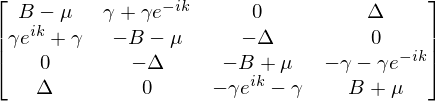

In [4]:
Hk=sympy.exp(sympy.I*k)*T+sympy.exp(-sympy.I*k)*T.transpose()+U
Hk

We can diagonalize this yealding the eigenvalues of the system:

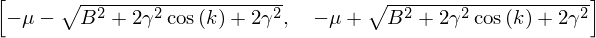

In [5]:
# this is where we will keep the eigenvalues of the BdG matrix
bdgspectr=list(Hk.eigenvals())
# in theis list we keep the eigenvalues of the particle block
wspect=list(
    ((sympy.exp(sympy.I*k).rewrite(sin)*T+
      sympy.exp(-sympy.I*k).rewrite(sin)*T.transpose()+
      U)[:2,:2]).eigenvals()
)
wspect

Since we have an explicitely real Bogoliubov-de Gennes matrix we can define a chiral symmetry as $\tau_1\sigma_0$. Whit the help of this symmetry we can transform the Bogoliubov-de Gennes matrix to a block off-diagonal form.

In [6]:
#Pauli matrices to be used in symbolic calculations
S1=sympy.physics.matrices.msigma(1)
S2=sympy.physics.matrices.msigma(2)
S3=sympy.physics.matrices.msigma(3)
S0=S1*S1

This is the Chiral symmetry operator

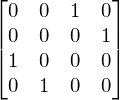

In [7]:
Kron(S1,S0)

The eigenvectors of this matrix give the unitary transformation necessary to block off-diagonalize the $\mathcal{H}$ matrix

In [8]:
P,D=Kron(S1,S0).diagonalize()

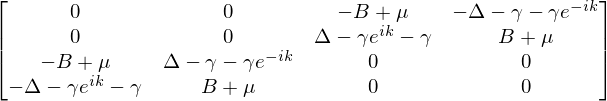

In [9]:
P*Hk*P.inv()

The Winding number of the determinant of the nonzero subblock will serve as a topological invariant for this model:

In [10]:
detblock=sympy.simplify((
    ((( P*( Hk  )*P.inv() )[:2,2:]).det())
).rewrite(sin))

Looking at the imaginary and real part of this quantity we recognize that it describes an ellipse:

In [11]:
sympy.re(detblock)

In [12]:
sympy.im(detblock)

From the above expressions we can infere the topological phase diagram of the system. While keeping a finite value of $\Delta$ tuning $\mu^2+\Delta^2-B^2$ in the intervall $[0,4\gamma^2]$ the system has a Winding number of one and hence is topological, otherwhise it is trivial.

Let us examine the winding and the spectrum as we tune the parameters of the system: 

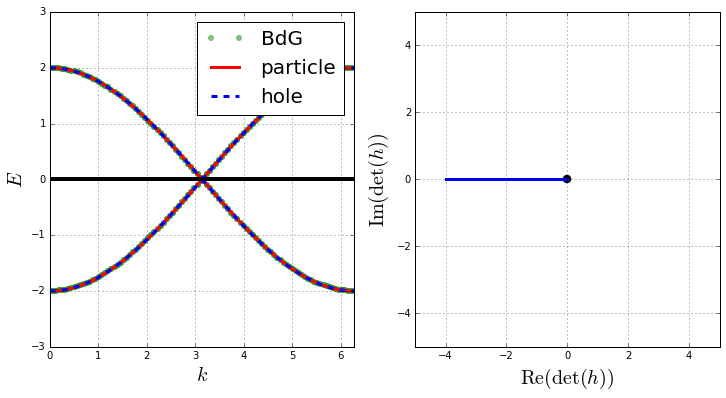

In [13]:
figsize(12,6)
@interact(mu=(-3,3,0.1),B=(0,2,0.1),gamma=fixed(1),Delta=(0,2,0.1))
def spectr_wire(mu=0,B=0,gamma=1,Delta=0):
    # this part produces the spectrum
    subplot(121)
    k=linspace(0,2*pi,100)    
    I=1j
    # evaluating the BdG spectra
    plot(k,real(eval(str(bdgspectr[0]))),
         'o',lw=3,label='BdG',mec='green',mfc='green',alpha=0.5,mew=0)
    for i in [1,2,3]:
        plot(k,real(eval(str(bdgspectr[i]))),
             'o',lw=3,mec='green',mfc='green',alpha=0.5,mew=0)
    # evaluating the particle and the hole spectra without superconductivity
    plot(k,eval(str(wspect[0])),'r-',lw=3,label='particle')
    plot(k,eval(str(wspect[1])),'r-',lw=3)
    plot(k,-eval(str(wspect[0])),'b--',lw=3,label='hole')
    plot(k,-eval(str(wspect[1])),'b--',lw=3)

    plot(k,0*k,'k-',lw=4)
    grid()
    xlim(0,2*pi)
    ylim(-3,3)
    xlabel(r'$k$',fontsize=20)
    ylabel(r'$E$',fontsize=20)
    legend(fontsize=20)
    # this part produces the winding plot
    subplot(122)
    plot(0,0,'ko',ms=8)
    plot(eval(str(sympy.re(detblock))),
         eval(str(sympy.im(detblock))),lw=3)
    xlabel(r'$\mathrm{Re}(\mathrm{det}(h))$',fontsize=20)
    ylabel(r'$\mathrm{Im}(\mathrm{det}(h))$',fontsize=20)
    
    grid()
    xlim(-5,5)
    ylim(-5,5)

Finally let us calculate the spectrum of a wire of finite length and let us look for zero energy excitations!


In [14]:
# this builds a BdG matrix of a finite system
def HgTe_wire_BDG_Ham(N=10,mu=0,B=0,gamma=1,Delta=0):
    idL=eye(N); # identity matrix of dimension L
    odL=diag(ones(N-1),1);# upper off diagonal matrix with ones of size L
    U=matrix([[-mu+B,gamma,0,Delta],
                 [gamma,-mu-B,-Delta,0],
                 [0,-Delta,mu-B,-gamma],
                 [Delta,0,-gamma,mu+B]])
    T=matrix([[0,0,0,0],
                 [gamma,0,0,0],
                 [0,0,0,0],
                 [0,0,-gamma,0]])
    return kron(idL,U)+kron(odL,T)+kron(odL,T).H

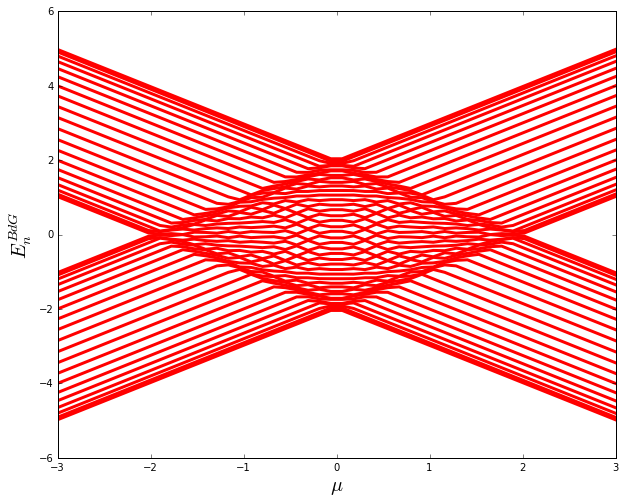

In [15]:
# calculate the spectrum as the function of chemical potential for different values of N,B and Delta
figsize(10,8)
uran=linspace(-3,3,50)
@interact(N=(10,20,1),B=(0,3,.1),Delta=(0,1,0.1))
def playBdG(N=10,B=0,Delta=0.2,):
    dat=[]
    for mu in uran:
        dat.append(eigvalsh(HgTe_wire_BDG_Ham(N,mu,B,1,Delta)))
    plot(uran,dat,'r',lw=3);
    xlabel(r'$\mu$',fontsize=20)
    ylabel(r'$E^{BdG}_n$',fontsize=20)
    
